# Morse grid imports

Here we look at applied examples to import data for use in Dr Peter Morse 3D visualtsation software _(in prep.)_. Data must be exported as $1800 \times 3600$ px 8-bit RGBA png files. This might change in future. 

In [44]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from scipy import interpolate

from grid import *

In this example, the data is global and we define a grid with the right rsolution from start. However, as we will see later, we could work on regional data as well. The exported png will always have a global coverage with alpha covering the excluded areas. 

We read depth values for smean from a provided ascii file. However we also have a regular depth dimention, defined as regular 50km depths. 

In [54]:
world = Grid(crs_tgt = 4326, 
             left= -180, upp=90, down= -90, right=180.0, 
             res=(0.099999999999,0.099999999999), 
             depths = range(50*km, 2900*km, 50*km))

world.ds.coords['SMEAN_Z'] = km * np.loadtxt('../data/SMEAN/smean/depths.dat')[::-1]
array = np.empty((world.ny, world.nx, len(world.ds.coords['SMEAN_Z'])))
array[:] = np.nan
print(world.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, SMEAN_Z: 29, X: 3600, Y: 1800, Z: 57)
Coordinates:
  * X        (X) float32 -180.0 -179.89998 -179.79994 ... 179.89998 180.0
  * Y        (Y) float32 90.0 89.89995 89.79989 ... -89.79989 -89.89995 -90.0
  * Z        (Z) float32 50000.0 100000.0 150000.0 ... 2800000.0 2850000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    YV       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lat      (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lon      (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
  * SMEAN_Z  (SMEAN_Z) float64 5e+04 1.5e+05 2.5e+05 ... 2.75e+06 2.85e+06
Data variables:
    *empty*


## SMEAN

Download the mantel model from from Becker and Boschi, Jackson School of Geosciences, The University of Texas at Austin. See original paper [Becker and_Boschi 2002](http://www-udc.ig.utexas.edu/external/becker/becker_and_boschi_2002.pdf) for details.

In [58]:
! mkdir -p data/smean
! wget -nc http://www-udc.ig.utexas.edu/external/becker/ftp/smean_grd.tgz \
    -O data/smean/smean_grd.tgz
! tar -xvzf data/smean/smean_grd.tgz -C data/smean/

File ‘data/smean/smean_grd.tgz’ already there; not retrieving.
x smean/
x smean/dvs.8.grd
x smean/dvs.15.grd
x smean/dvs.29.grd
x smean/dvs.17.grd
x smean/dvs.28.grd
x smean/convert
x smean/dvs.27.grd
x smean/dvs.22.grd
x smean/dvs.20.grd
x smean/dvs.6.grd
x smean/dvs.11.grd
x smean/dvs.1.grd
x smean/dvs.13.grd
x smean/depths.dat
x smean/dvs.9.grd
x smean/dvs.24.grd
x smean/dvs.7.grd
x smean/dvs.14.grd
x smean/dvs.4.grd
x smean/dvs.23.grd
x smean/README
x smean/dvs.5.grd
x smean/dvs.19.grd
x smean/dvs.16.grd
x smean/dvs.25.grd
x smean/dvs.10.grd
x smean/dvs.21.grd
x smean/dvs.12.grd
x smean/dvs.18.grd
x smean/dvs.26.grd
x smean/dvs.2.grd
x smean/dvs.3.grd


Now, we can read SMEAN files. set_senter alows us to read 0-360 as -180 - 180 lon. read_grid uses default nearest neighbour interpolation of datapoints to fit the predefined Morse grid. 

In [59]:
for i, a in enumerate(world.ds['SMEAN_Z'].values):
    print(world.ds['SMEAN_Z'].size - i, a//km, end=' ')
    index_name = world.ds['SMEAN_Z'].size - i # Get right file name for each depth
    fname = '../data/SMEAN/smean/dvs.%s.grd'%(index_name)
    if os.path.isfile(fname):
        array[:,:,i] = world.read_grid(fname, xyz = ('lon','lat','z'), set_center = True)
world.ds['SMEAN'] = (('Y', 'X', 'SMEAN_Z'), array)

29 50.0 28 150.0 27 250.0 26 350.0 25 450.0 24 550.0 23 650.0 22 750.0 21 850.0 20 950.0 19 1050.0 18 1150.0 17 1250.0 16 1350.0 15 1450.0 14 1550.0 13 1650.0 12 1750.0 11 1850.0 10 1950.0 9 2050.0 8 2150.0 7 2250.0 6 2350.0 5 2450.0 4 2550.0 3 2650.0 2 2750.0 1 2850.0 

However, we might also be interesetd in regular sampled depth slices. Here we interpolate perturbation values to a regular grid. This function interpolates new depth values for each grid cell, so it might take a while: 

In [60]:
world.ds['SMEAN_INTER'] = ( ('Y', 'X', 'Z'), 
                           world.change_coord(world.ds['SMEAN'], world.ds['SMEAN_Z'], world.ds['Z']) )

Finally, we export the 3D grids as png files for each depth slice. We store a set of original depth slices in ''morse/smean/z_orig/' and also the interpolated depth slices in 'morse/smean/z_even/'. This might take some time. 

In [ ]:
array_min = np.nanmin(world.ds['SMEAN'].values)
array_max = np.nanmax(world.ds['SMEAN'].values)

print(array_min, array_max)

In [61]:
for i, z in enumerate(world.ds['Z']):
    report = world.export_morse_png(world.ds['SMEAN_INTER'].isel(Z=i).values, 'morse/smean/z_even/%04d_%s_smean.png'%(int(z)//km, i+1), 
                          v_min = array_min, v_max = array_max, set_geometry = False)

-8.248665446939413 6.736401051359279


In [ ]:
for i, z in enumerate(world.ds['SMEAN_Z']):
    report = world.export_morse_png(world.ds['SMEAN'].isel(SMEAN_Z=i).values, 'morse/smean/z_orig/%04d_%s_smean.png'%(int(z)//km, i+1), 
                          v_min = array_min, v_max = array_max, set_geometry = False)

## GLAD M15

Now let's import the model from [Bozdağ et al (2016)](https://academic.oup.com/gji/article/207/3/1739/2404568). Unfortunately, it appears that the data is not availible from any open repo, but I belive that the group is willing to assist if contacted. 

The SMEAN data was easy to import, but exporting the GLAD-M15 data is more compicated as we only get access to an unstructured grid. 

In [65]:
# load a vtk file to reader
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName('../data/GLAD-M15/reg_1_dvsv.vtu')
reader.Update()

# Get the coordinates of nodes in the mesh
nodes_vtk_array= reader.GetOutput().GetPoints().GetData()

#The data field is the first scalar in the vtu file
data_vtk_array = reader.GetOutput().GetPointData().GetArray(0)

print(data_vtk_array, nodes_vtk_array)

vtkFloatArray (0x7faeab300b00)
  Debug: Off
  Modified Time: 1057
  Reference Count: 2
  Registered Events: (none)
  Name: Scalars_
  Data type: float
  Size: 4712064
  MaxId: 4712063
  NumberOfComponents: 1
  Information: 0x7faeab301930
    Debug: Off
    Modified Time: 1056
    Reference Count: 1
    Registered Events: (none)
  Name: Scalars_
  Number Of Components: 1
  Number Of Tuples: 4712064
  Size: 4712064
  MaxId: 4712063
  LookupTable: (none)

 vtkFloatArray (0x7faeab303ce0)
  Debug: Off
  Modified Time: 1065
  Reference Count: 2
  Registered Events: (none)
  Name: Points
  Data type: float
  Size: 14136192
  MaxId: 14136191
  NumberOfComponents: 3
  Information: 0x7faeab303dd0
    Debug: Off
    Modified Time: 1064
    Reference Count: 1
    Registered Events: (none)
  Name: Points
  Number Of Components: 3
  Number Of Tuples: 4712064
  Size: 14136192
  MaxId: 14136191
  LookupTable: (none)




We get two arrays. Note that sizes are equal (Number Of Tuples: 4712064 and Number Of Tuples: 4712064) and the coordinate are 3D (NumberOfComponents: 3). Read coordinates and data as numpy arrays and have a look: 

In [143]:
nodes_numpy_array = vtk_to_numpy(nodes_vtk_array)
x,y,z= nodes_numpy_array[:,0] , nodes_numpy_array[:,1] , nodes_numpy_array[:,2]
v = vtk_to_numpy(data_vtk_array)

print(x[:10],y[:10],z[:10],v[:10], sep='\n\n')

[0.5691442  0.5688175  0.564466   0.56416    0.5717007  0.57395065
 0.5670015  0.5692511  0.5572726  0.55697674]

[-0.5621991  -0.55501693 -0.564466   -0.5572726  -0.56472445 -0.5600256
 -0.5670015  -0.56230164 -0.56416    -0.55697674]

[0.58328736 0.58295256 0.58563924 0.5853217  0.5859074  0.58821326
 0.5882699  0.5906039  0.5853217  0.585011  ]

[ 0.00667072 -0.00163048  0.00903202  0.00080819  0.04597764  0.04589656
  0.04808749  0.04804029  0.00308752 -0.00534776]


The coordinates are stored in the range [-1..1]. We assume a spherical Earth and compute an array with every points distance from centre. Function `sphere_to_layer()` takes a slice from the sphere and save to a 2D array. delta_r should be as small as possible, for best vertical resolution, but if too few points are used the vertical resolution gets bad. 

We loop through the harmonics of the sphere and read all points within a spherical shell defined by the radius +/- delta_r

In [146]:
def sphere_to_layer(x,y,z,d, shape, 
                    delta_r = 32*km, 
                    min_s = 5000,
                    r_earth =  (6357*km + 6378*km) / 2):
    
    _array = np.zeros(shape).astype('float')
    upper = 1-(d-delta_r)/r_earth
    lower = 1-(d+delta_r)/r_earth
    s = (r > lower) & (r < upper)
    s_sum = np.count_nonzero(s)
    lat = lat_all[s]
    lon = lon_all[s]

    if s_sum >= min_s:
        _array = interpolate.griddata((lon*a+1800, lat*a+900),
                v[s], (xxx, yyy), method = 'nearest')
        print(d//1000, 'km', sum(s),'-> %s' %np.nanmean(_array))
    else:
        _array = np.nan
        print(d//1000, 'km', sum(s),'-> nan')
    return np.flip(_array, 0) #Because ulike lat, rows start from top. 

r = np.sqrt(x*x + y*y + z*z) 
a = 3600//360

lat_all = np.arccos( z / r) * 180/np.pi - 90
lon_all = np.arctan2(y, x) * 180/np.pi

xxx, yyy = np.meshgrid(range(0,360*a), range(180*a, 0, -1)) 

shape = (1800, 3600, world.ds['SMEAN_Z'].size)
glad = np.zeros(shape)

for i, d in enumerate(world.ds['SMEAN_Z'].values):
    glad[:,:,i] = sphere_to_layer(x,y,z,d, shape[:1])


50.0 km 639360 -> 0.023831118
150.0 km 221952 -> 0.0038557963
250.0 km 110976 -> 0.002156455
350.0 km 110976 -> 0.00014414245
450.0 km 110976 -> -0.0009187652
550.0 km 110976 -> -0.001315901
650.0 km 110976 -> -0.001345703
750.0 km 110976 -> -0.0006769211
850.0 km 110976 -> -0.00050527515
950.0 km 110976 -> -0.0004993277
1050.0 km 110976 -> -0.00042126115
1150.0 km 110976 -> -0.00036263856
1250.0 km 110976 -> -0.0003149335
1350.0 km 0 -> nan


AxisError: axis 0 is out of bounds for array of dimension 0

Unfortunately there are not enugh data points at 1350, 1450 2150 and 2250 km depth. We'd need a very broad acceptance shell to get datapoints. Let's get some data for those depths as well: 

In [140]:
missing_i, missing_d = [], []

for i in range(glad.shape[2]):
    if (np.count_nonzero(np.isnan(glad[:,:,i]) ) != 0):
        missing_i.append(i)
        missing_d.append(world.ds['SMEAN_Z'].values[i])

print(missing_i, missing_d)

for i,d in zip(missing_i, missing_d):
    print(i,d)
    glad[:,:,i] = sphere_to_layer(x,y,z,d, shape[:1], delta_r = 45*km)
    

[] []


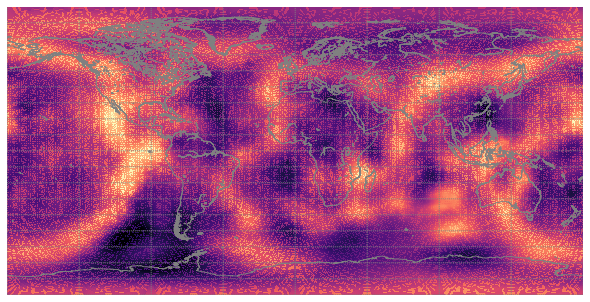

In [145]:
world.map_grid(world.ds['GLAD'].isel(SMEAN_Z=0), cmap='magma_r')

In [115]:
world.ds['GLAD_Z'] = (('Y', 'X', 'Z'), glad_z)


array_min = np.nanmin(world.ds['GLAD_Z'].values)
array_max = np.nanmax(world.ds['GLAD_Z'].values)

print(array_min, array_max)

-0.08853175491094589 0.08279302716255188


In [116]:
world.ds['DIFF'] = world.ds['GLAD']-world.ds['SMEAN']

In [121]:
for i, z in enumerate(world.ds['SMEAN_Z']):
    report = world.export_morse_png(world.ds['GLAD'].isel(SMEAN_Z=i).values, 
                                    'morse/glad/z_even/%04d_%s_smean.png'%(int(z)//km, i+1), 
                          v_min = array_min, v_max = array_max, set_geometry = False)
    with open("morse/glad/z_even/log.txt", "a") as log_file:
        log_file.write(report)
    print(report)


morse/glad/z_even/0050_1_smean.png 
min v: -0.08853175491094589 max v: 0.08279302716255188 bit depth: 8
bands: 4 interpolation: nearest
v 	  norm 	  to png 	 png 
-0.089 	  0.000 	 0 	  0 
0.118 	  1.204 	 255 	  255 


morse/glad/z_even/0150_2_smean.png 
min v: -0.08853175491094589 max v: 0.08279302716255188 bit depth: 8
bands: 4 interpolation: nearest
v 	  norm 	  to png 	 png 
-0.062 	  0.158 	 0 	  0 
0.086 	  1.017 	 255 	  255 


morse/glad/z_even/0250_3_smean.png 
min v: -0.08853175491094589 max v: 0.08279302716255188 bit depth: 8
bands: 4 interpolation: nearest
v 	  norm 	  to png 	 png 
-0.042 	  0.269 	 68 	  68 
0.054 	  0.832 	 212 	  212 


morse/glad/z_even/0350_4_smean.png 
min v: -0.08853175491094589 max v: 0.08279302716255188 bit depth: 8
bands: 4 interpolation: nearest
v 	  norm 	  to png 	 png 
-0.029 	  0.348 	 88 	  88 
0.036 	  0.726 	 185 	  185 


morse/glad/z_even/0450_5_smean.png 
min v: -0.08853175491094589 max v: 0.08279302716255188 bit depth: 8
bands: 4 in

In [ ]:
l = 0

print(np.nanmin(glad_z[:,:,l]), np.nanmax(glad_z[:,:,l]))
fig, ax = plt.subplots(1, 1, figsize=(19,12))

ax.imshow(glad_z[:,:,l])
plt.show()

-0.08853175491094589 0.08279302716255188


In [114]:
for i, z in enumerate(world.ds['Z']):
    report = world.export_morse_png(world.ds['SMEAN'].isel(Z=i).values, 'morse/smean/z_even/%04d_%s_glad.png'%(int(z)//km, i+1), 
                          v_min = array_min, v_max = array_max, set_geometry = False)

ValueError: dimensions ['Z'] do not exist

In [ ]:
delta_d = 25
depths = world.ds['Z'].values//1000

glad_z = np.zeros((3600, 1800, world.ds['Z'].size))

for i, d in enumerate(world.ds['Z'].values):
    upper = 1-(d-delta_d)/r_earth
    lower = 1-(d+delta_d)/r_earth
    s = (r_km > lower) & (r_km < upper)
    lat = np.arccos( z[s] / r_km[s]) * 180/np.pi - 90
    lon = np.arctan2(y[s], x[s]) * 180/np.pi
    print(d, upper, lower, np.sum(s))
    try:
        glad_z[:,:,i] = interpolate.griddata((lon, lat), 
            v[s], (xxx, yyy), method = 'nearest')
    except:
        glad_z[:,:,i] = np.nan

In [ ]:
world.ds['GLAD'] = (('Y', 'X', 'Z'), np.transpose(glad_z, (1, 0, 2)))


#array_min = np.nanmin(array)
#array_max = np.nanmax(array)

In [ ]:
#for i, z in enumerate(world.ds['Z']):
#    report_z = world.export_morse_png(world.ds['GLAD_INTER'].isel(SMEAN_Z=i).values, 'morse/glad/z_even/%04d_%s_glad.png'%(int(z)//km, i+1), 
#                          v_min = array_min, v_max = array_max, set_geometry = False)
#    print(report)
    
for i, z in enumerate(world.ds['SMEAN_Z']):
    report_z = world.export_morse_png(world.ds['GLAD'].isel(SMEAN_Z=i).values, 'morse/glad/z_orig/%04d_%s_glad.png'%(int(z)//km, i+1), 
                          v_min = array_min, v_max = array_max, set_geometry = False)
    print(report)

In [ ]:
np.shape(glad_z)

fig, ax = 
ax.imshow(glad_z[:,:,0])
plt.show()

In [128]:
ant = Grid(crs_tgt = 3031, 
             left= -1000*km, upp=1000*km, down= -2000*km, right=3000*km, 
             res=(50*km, 50*km), 
             depths = range(50*km, 200*km, 10*km))

In [130]:
ant.ds

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 80, Y: 60, Z: 15)
Coordinates:
  * X        (X) float32 -1000000.0 -949367.06 -898734.2 ... 2949367.0 3000000.0
  * Y        (Y) float32 1000000.0 949152.56 898305.06 ... -1949152.5 -2000000.0
  * Z        (Z) float32 50000.0 60000.0 70000.0 ... 170000.0 180000.0 190000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(60, 80), chunksize=(6, 8)>
    YV       (Y, X) float32 dask.array<shape=(60, 80), chunksize=(6, 8)>
    lat      (Y, X) float32 dask.array<shape=(60, 80), chunksize=(6, 8)>
    lon      (Y, X) float32 dask.array<shape=(60, 80), chunksize=(6, 8)>
Data variables:
    *empty*

In [136]:
ant.ds['BEDMAP'] = (('Y', 'X'), 
                ant.read_raster('../data/bedmap2_tiff/bedmap2_bed.tif'))

CRS({'init': 'epsg:3031'})


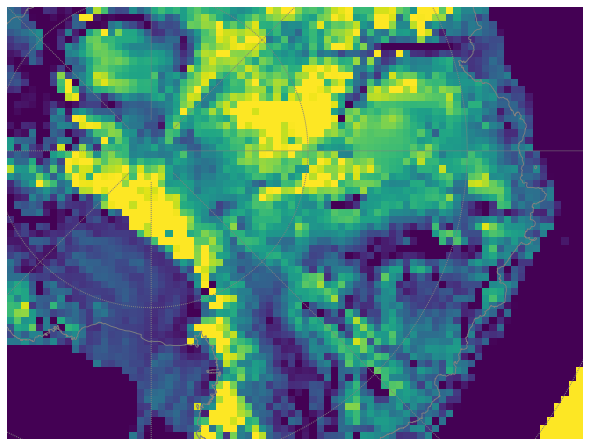

In [137]:
ant.map_grid('BEDMAP', cmap='viridis', vmin=-1000, vmax=1000)

In [138]:
ant.nx

80

In [139]:
ant.nn

(80, 60)